In [ ]:
#Uncomment next line if you are using Google Colaboratory
#!pip install pycuda

In [1]:
import  numpy  as  np
import  pycuda.autoinit
from    pycuda.compiler import SourceModule
import  pycuda.driver as  drv
import  pycuda.gpuarray as  gpuarray
import  pycuda.tools as gtools
from numpy import linalg as la
from IPython import display
import time

# Guide to use Tiled Algorithms
Whe we want to use tiled memory based algorithms, we need to analize the follow steps:
1) Tiled Memory Size: What information we will share across all the execution threads in an execution block
2) Assign the memory position to each execution thread with memory coalesence
3) Fill the Tiled Memory in parallel
4) Assign to some threads the extra data needed for the algorithms
5) Synchronize the filling memory execution
6) Each thread executes his individual task
7) Synchronize the task execution
8) End the execution

# TILED REDUCTION ARRAY
The algorithm of reduction (which calculates the sum of all elements in an array), works as follow:

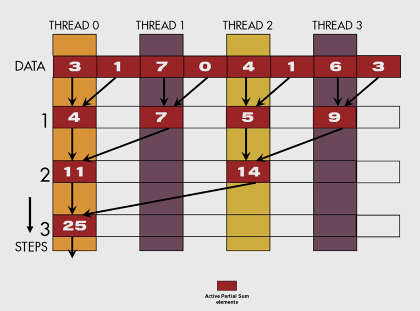

* Tiled memory size: The tile will contain the twice times the number of threads assigned
* Each thread in the execution block copies the data from global memory to the assigned memory place
* No extra data need (for this task)
* In each iteration
    * Adds the position assigned and the next available data (indexed by the stride)
    * This will work until the stride exceeds the block size

In [3]:
tiled_reduction_src = """
__global__ void tiled_reduction( float *v, float *c, int N) {

  const int BLOCK_SIZE = 1024;

  __shared__ float partialSum[ 2 * BLOCK_SIZE ]; //The array dimensions MUST be constants

  unsigned int t = threadIdx.x;
  unsigned int start = 2 * blockIdx.x * blockDim.x;

  
  //fill the tile memory
  //each thread will fill the memory position start + t and start + blockDim.x + t
  //look, each consecutive execution thread (threadIdx.x) will access to coalesced memory in both steps
  
  if ( (start+t) < N ) 
    partialSum[t] = v[start+t];
  else 
    partialSum[t] = 0;

  if ( (start + blockDim.x + t) < N )
    partialSum[blockDim.x + t] = v[start + blockDim.x + t];
  else
    partialSum[blockDim.x + t] = 0;

  //Here we will wait until all execution threads fills te memory
  __syncthreads();

  for ( unsigned int stride = 1; stride <= blockDim.x; stride*=2 ) {
    __syncthreads();
    if ( t % stride == 0)
      partialSum[2*t] += partialSum[2*t+stride];
  }
  c[blockIdx.x] = partialSum[0];
}
"""

Here we can not edit automatically the source template to use the string % function to replace character chains in the string variable by other values. 

The problem to use modern strings formating (format method or f-strings) is the collision of the use of {} symbols, and in the previos source code, the presence of modulus operator (%) collides with the string subtitution.

In further codes we will use it to be able to substitute constants values from external variables.

In [4]:
#Is the BLOCK_SIZE A GOOD BLOCK SIZE????
BLOCK_SIZE = 1024

In [5]:
print(tiled_reduction_src)


__global__ void tiled_reduction( float *v, float *c, int N) {

  const int BLOCK_SIZE = 1024;

  __shared__ float partialSum[ 2 * BLOCK_SIZE ]; //The array dimensions MUST be constants

  unsigned int t = threadIdx.x;
  unsigned int start = 2 * blockIdx.x * blockDim.x;

  
  //fill the tile memory
  //each thread will fill the memory position start + t and start + blockDim.x + t
  //look, each consecutive execution thread (threadIdx.x) will access to coalesced memory in both steps
  
  if ( (start+t) < N ) 
    partialSum[t] = v[start+t];
  else 
    partialSum[t] = 0;

  if ( (start + blockDim.x + t) < N )
    partialSum[blockDim.x + t] = v[start + blockDim.x + t];
  else
    partialSum[blockDim.x + t] = 0;

  //Here we will wait until all execution threads fills te memory
  __syncthreads();

  for ( unsigned int stride = 1; stride <= blockDim.x; stride*=2 ) {
    __syncthreads();
    if ( t % stride == 0)
      partialSum[2*t] += partialSum[2*t+stride];
  }
  c[blockIdx.x] = partial

In [14]:
mod = SourceModule(tiled_reduction_src)
tiled_reduction = mod.get_function("tiled_reduction")

In [15]:
datasize = np.int32(1000000)
data = np.random.randn(datasize).astype(np.float32)
data_gpu = gpuarray.to_gpu(data)

In [16]:
block_size = (int(BLOCK_SIZE),1,1)
numblocks = int(np.ceil(datasize/BLOCK_SIZE))
c_gpu = gpuarray.empty((numblocks,1),np.float32)
grid_size = (numblocks,1)

In [26]:
start_t = time.time()
tiled_reduction(data_gpu,
                c_gpu,
                datasize,
                grid=grid_size,
                block=block_size)
end_t = time.time()

In [27]:
c = c_gpu.get()

In [28]:
sum(data)

347.0500183024633

In [29]:
np.sum(c)

347.05

In [30]:
print(end_t - start_t)

0.010559558868408203


# 1D Convolution

The algorithm to implement will calculate the convolution between 2 arrays.

The shortest array, called system mask, system response, represents the exit of a system to an special signal called Dirac's delta (signal of infinite height, but limited area under the curve).

The second array (the longest one) is the signal to be shaped by our system.

Based on this mathematical operation the filters works.

The Image Filter algorithms are 2 dimensional convolutions.<br>

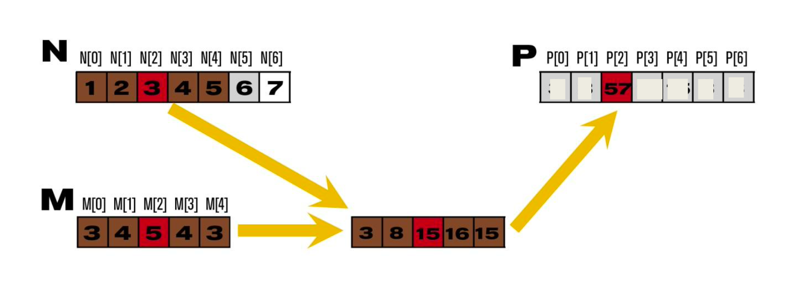

The problem with the tile algorithms is that we need extra data to calculate the the correct convolution (halos)<br>

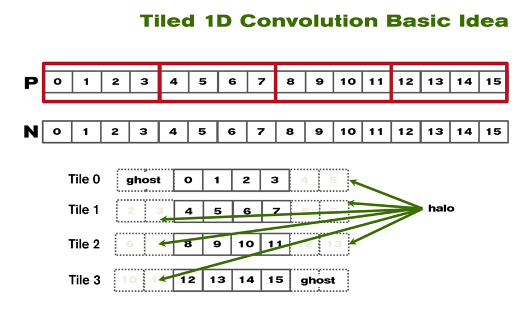

Then, our steps to implement the algorithm will be:

* Tiled memory size: The tile will contain not only the block size elements, but also the system mask length - 1, to store the halos. Also, we need to store in memory the shared memory the system mask. 
* Each thread in the execution block copies the data from global memory to the assigned memory place, and few of them will fill the halos.<br>

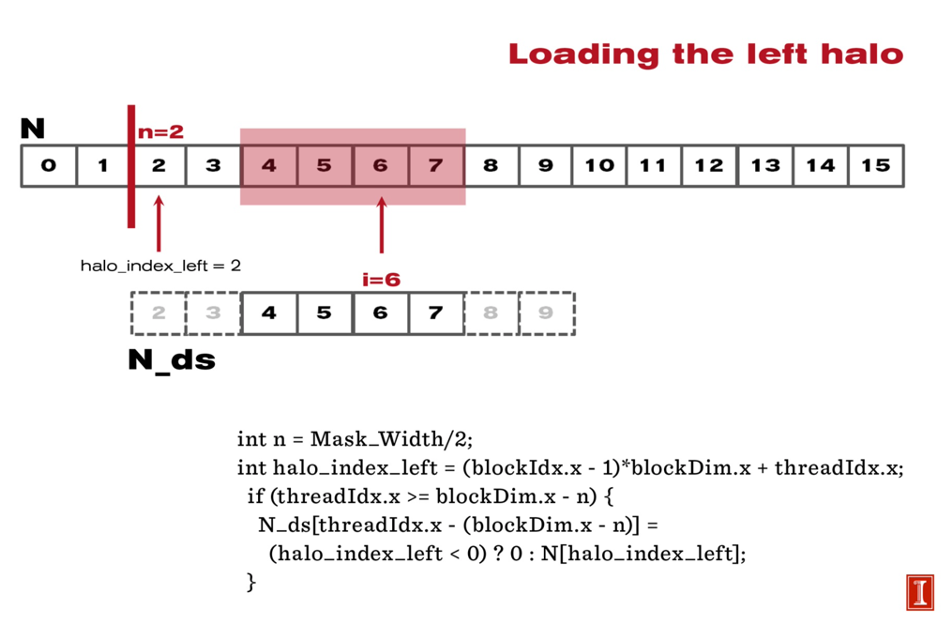

<br/>

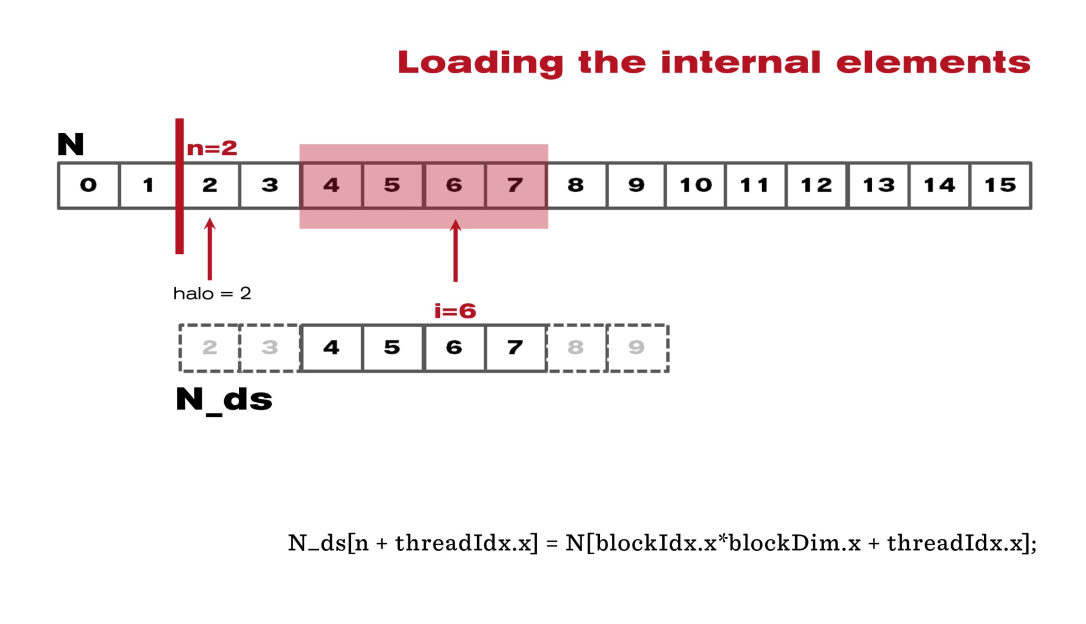
<br/>

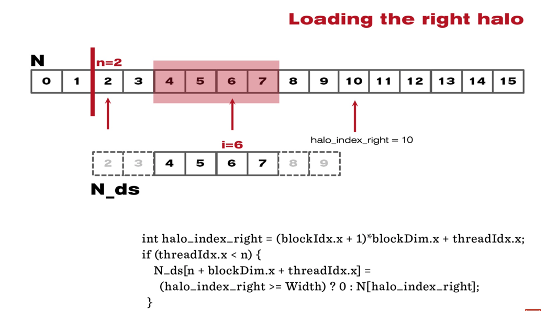

<br/>
* Once filled the assigned memory positions, we have to wait for the other tasks (\_\_syncthreads())
* Now, we have to calculate the convolution between the system mask and the assigned memory position in the signal vector.

You have to implement the algorithms in the follow cell.



In [57]:
convolution_tmp = """
__global__ void convolution( float *v, 
                             float *c, 
                             float *conv,
                             int N,
                             int c_size){

  __shared__ float tile[ %(TILE_SIZE)s ];
  __shared__ float mask[ %(MASK_SIZE)s ];

  unsigned int t = threadIdx.x;
  unsigned int start = blockIdx.x * blockDim.x;
  unsigned int offset = %(MASK_SIZE)s / 2;

  if (start + t < N) {
    tile[t + offset] = v[start + t];
  } else {
    tile[t + offset] = 0.0;
  }

  // analyzing beginning of the vector
  if (t < offset)
    if (blockIdx.x > 0)
      tile[t] = v[start+t-2]; // if t==0, we will fetch memory position start-2, if t==1, we will fetch position start-1
    else
      tile[t] = 0.0;

  // analyzing the end of the vector
  if (t > (blockDim.x - offset - 1))
    if ((t + start + offset) < N)
      tile[t + offset] = v[start + t + offset];
    else
      tile[t + offset] = 0.0; // will point to element in next block

// filling the mask
  if ( t < %(MASK_SIZE)s)
    mask[t] = conv[t];



  //fill the tile memory
  //IN THIS SECTION SHOULD FILL THE TILE MEMORY AND MAYBE THE MASK
  // all variables in chip memory

  __syncthreads();
  // calculate the convolution

  float accu = 0;
  c[]

  __syncthreads();
  c[blockIdx.x] = accu;
}
"""

In [53]:
filtermask = np.array([1,1,3,1,1],dtype=np.float32)
flitermask_gpu = gpuarray.to_gpu(filtermask)
filtermask_size = np.int32(5)

gówno jebane niewiaddomo co zrobić typ chuja gada po angielsku, kopi kopi kurwa memory mać

Jeszcze kurwa jezus maria arias fisteusz z web applications jebanych po co mi to było 

In [54]:
convolved_gpu = gpuarray.empty((datasize,1),np.float32)

In [45]:
BLOCK_SIZE = 256

In [46]:
MASK_SIZE = 5

In [47]:
TILE_SIZE = BLOCK_SIZE + MASK_SIZE - 1

In [55]:
convolution_src = convolution_tmp%{
'TILE_SIZE': BLOCK_SIZE,
'MASK_SIZE': MASK_SIZE
}

In [56]:
mod2 = SourceModule(convolution_src)

/tmp/ipykernel_4837/2319235238.py:1: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(9): warning #177-D: variable "tile" was declared but never referenced

kernel.cu(10): warning #177-D: variable "mask" was declared but never referenced

kernel.cu(12): warning #177-D: variable "t" was declared but never referenced

kernel.cu(13): warning #177-D: variable "start" was declared but never referenced

kernel.cu(14): warning #177-D: variable "offset" was declared but never referenced


  mod2 = SourceModule(convolution_src)


In [ ]:
convolution = mod.get_function("convolution")

In [ ]:
grid_size=(BLOCK_SIZE,1,1)

In [ ]:
numblocks= np.int(np.ceil(n/BLOCK_SIZE))
block_size=(numblocks,1)

In [ ]:
start_t = time.time()
convolution(data_gpu,
            convolved_gpu,
            filtermask_gpu,
            datasize,
            filtermask_size,
            grid=grid_size,
            block=block_size)
end_t=time.time

In [ ]:
local_convolved=np.convolve(data,filtermask,mode='full')

In [ ]:
convolved=convolved_gpu.get()